---
# 8. 뉴스 요약봇 만들기 [프로젝트]
## 8.1. 프로젝트: 뉴스기사 요약해보기

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


---
### Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
68797,Arvind Subramanian's term as CEA extended for ...,The government has extended the term of Chief ...
94934,Shiv Sena MPs threaten protest over Air India ...,Shiv Sena MPs on Wednesday threatened to disru...
82374,CISF security at Delhi Airport wins world's be...,The CISF security cover at the Delhi Airport h...
43124,Punjab to impose permanent ban on hookah bars,The Punjab Cabinet on Monday decided to amend ...
74085,"Tripura to partner BCCI in building 25,000-cap...",The Tripura Cricket Association (TCA) in assoc...
93026,"Pollution, poor visibility reported in Chenani...","Infrastructure Leasing and Financial Services,..."
29944,Congress-JD(S) to face floor test in Karnataka...,The floor test of the Congress-JD(S) alliance ...
34697,Sunil Grover to feature in Salman Khan's 'Bhar...,"According to reports, comedian Sunil Grover wi..."
34516,"10 killed, 100 injured in anti-govt protests i...","At least 10 people, including a police officer..."
53533,Toddler killed as suicidal man falls on him fr...,A toddler was killed in Ukraine when a man all...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

---
### Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

**데이터 정리하기**

데이터 정제

In [7]:
# 중복 샘플과 NULL 값이 존재하는 샘플 제거
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
# 결측값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화

In [11]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 제거

In [13]:
# NLTK 패키지에서 불용어 사전 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# 불용어 리스트
from nltk.corpus import stopwords

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [18]:
import re
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

text, headlines 데이터 전처리

In [20]:
# 전체 Text 데이터에 대한 전처리
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [21]:
# 전체 Headlines 데이터에 대한 전처리
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [23]:
import numpy as np

In [24]:
# 빈 샘플 확인
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [25]:
# 전처리 후 결측치 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

**훈련, 테스트 데이터 나누기**

text_max_len, headlines_max_len을 정하기 전 적절한 maxlen 찾는 과정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


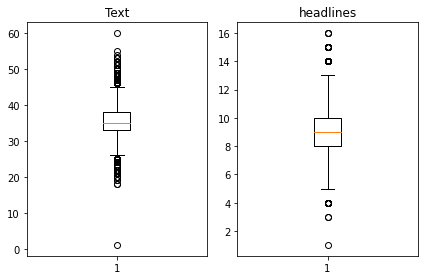

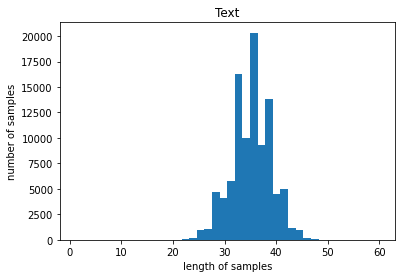

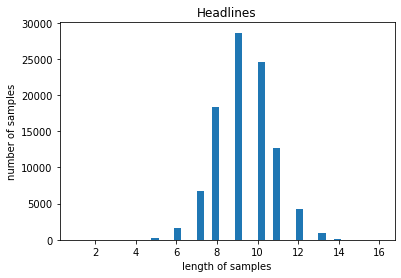

In [26]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [35]:
# 평균과 그래프 분포를 확인하고 적절한 비율 선택해보기
below_threshold_len(41, data['text'])
below_threshold_len(11, data['headlines'])

전체 샘플 중 길이가 41 이하인 샘플의 비율: 0.9549613664091094
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [36]:
# 위 과정을 통해 선택한 각 maxlen값 부여
text_max_len = 41
headlines_max_len = 11

In [40]:
data = data[
    data['text'].apply(lambda x: len(x.split()) <= text_max_len) &  # Text 길이 조건
    data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)  # Headlines 길이 조건
]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88749


In [42]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

/tmp/ipykernel_61/4081104566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_61/4081104566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [44]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [45]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[36690 47655  7625 ...  5075 74770 27606]


In [46]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

데이터셋 분리

In [47]:
# 테스트 데이터의 비율을 20%로 데이터 분할시 테스트 데이터 수 확인
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17749


In [48]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71000
훈련 레이블의 개수 : 71000
테스트 데이터의 개수 : 17749
테스트 레이블의 개수 : 17749


**정수 인코딩**

In [49]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [50]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65990
등장 빈도가 6번 이하인 희귀 단어의 수: 45005
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20985
단어 집합에서 희귀 단어의 비율: 68.1997272313987
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7067711266049748


In [51]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [52]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[11, 580, 2914, 3538, 183, 11798, 18352, 3691, 402, 29, 399, 96, 173, 590, 127, 848, 941, 258, 11798, 1844, 556, 333, 953, 50, 3640, 9816, 1091, 2642, 45, 402, 113, 973, 416, 3538, 1], [195, 5325, 1833, 2214, 3663, 102, 9439, 30, 235, 139, 13459, 338, 436, 200, 451, 1, 2100, 2602, 5623, 30, 6562, 114, 1878, 32, 4985, 1800, 1416, 1087, 30, 315, 358, 172, 1189, 1833, 1497, 100, 139], [26, 6563, 136, 19, 58, 10284, 169, 1573, 51, 89, 144, 2208, 155, 3512, 8561, 15077, 418, 1975, 2870, 71, 12, 1387, 29, 174, 829, 12, 6385, 26, 4299, 160, 15, 2516, 138]]


In [53]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [54]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28901
등장 빈도가 5번 이하인 희귀 단어의 수: 19002
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9899
단어 집합에서 희귀 단어의 비율: 65.74859001418636
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.076475490693963


In [55]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 123, 199, 12, 632, 43, 353, 649, 219, 411], [1, 95, 340, 138, 13, 6, 1697, 651], [1, 70, 90, 1677, 4, 275, 1265, 1548, 66], [1, 53, 19, 47, 12], [1, 8, 291, 64, 564, 87, 53, 65, 28, 965]]
target
decoder  [[123, 199, 12, 632, 43, 353, 649, 219, 411, 2], [95, 340, 138, 13, 6, 1697, 651, 2], [70, 90, 1677, 4, 275, 1265, 1548, 66, 2], [53, 19, 47, 12, 2], [8, 291, 64, 564, 87, 53, 65, 28, 965, 2]]


In [56]:
# 빈도수가 낮은 단어를 삭제해서 빈샘플이 된 데이터 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 11
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 70989
훈련 레이블의 개수 : 70989
테스트 데이터의 개수 : 17748
테스트 레이블의 개수 : 17748


In [58]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

---
### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

**모델 설계하기**

In [59]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [60]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [61]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

**어텐션 메커니즘**

In [62]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

**모델 훈련하기**

In [63]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
278/278 [==============================] - 25s 65ms/step - loss: 4.1613 - val_loss: 3.8761
Epoch 2/50
278/278 [==============================] - 17s 62ms/step - loss: 3.6904 - val_loss: 3.5608
Epoch 3/50
278/278 [==============================] - 17s 62ms/step - loss: 3.3906 - val_loss: 3.3200
Epoch 4/50
278/278 [==============================] - 18s 63ms/step - loss: 3.1781 - val_loss: 3.1667
Epoch 5/50
278/278 [==============================] - 18s 64ms/step - loss: 3.0222 - val_loss: 3.0575
Epoch 6/50
278/278 [==============================] - 18s 65ms/step - loss: 2.8966 - val_loss: 2.9634
Epoch 7/50
278/278 [==============================] - 18s 66ms/step - loss: 2.7915 - val_loss: 2.9084
Epoch 8/50
278/278 [==============================] - 18s 66ms/step - loss: 2.6993 - val_loss: 2.8443
Epoch 9/50
278/278 [==============================] - 18s 66ms/step - loss: 2.6202 - val_loss: 2.8177
Epoch 10/50
278/278 [==============================] - 18s 66ms/step - loss: 2.549

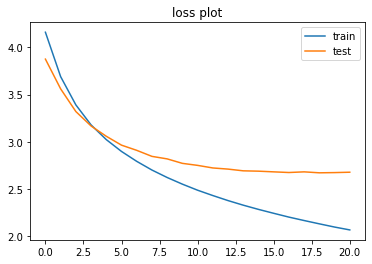

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("loss plot")
plt.legend()
plt.show()

**loss plot 추이**
- 훈련이 거듭되며 epoch가 커져감에 따라 train, val loss가 줄어듬 **(성공적인 학습)**
- epoch가 19회에 다다르자 과대적합이 일어남
- epochs를 50으로 지정했지만 EarlyStopping 콜백 함수로 21회에 훈련이 종료

---
### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [65]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [66]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [67]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

**모델 테스트하기**

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0:  # 정수 0은 padding을 의미하므로 이를 제외
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [73]:
# 추상적 요약
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : new make trend emerged online beauty make artists creating look make faces look like melting ice cream look completed placing real artificial ice cream heads sometimes even top make 
실제 요약 : sostoken create make up look inspired by ice 
예측 요약 :  new to create


원문 : bahujan samaj party chief mayawati said party agree alliance election gets share seats otherwise contest alone added mayawati said opposition parties try best ensure bjp win upcoming assembly elections states lok sabha elections nn 
실제 요약 : sostoken ready for alliance if gets seat share mayawati 
예측 요약 :  will not contest any alliance with akhilesh


원문 : amitabh bachchan confirmed back host ninth season quiz show kaun banega crorepati bachchan personal blog wrote contest air august september year revealed contestants spending many hours hot seat would end becoming dearest friends 
실제 요약 : sostoken bachchan to return as host of season 
예측 요약 :  amitabh bachchan to be at


원문 : lionel messi set goals luis suarez barcelo

**추상적 요약**
- 실제 요약은 원문의 내용을 제대로 담고 있는 반면, 예측 요약은 허술하게 요약된 것 확인
    - ex-1. 첫 번째 원문에서 new to create "sth"에 대한 정보가 더 필요하다.
    - ex-2. 세 번째 원문에서는 'to be at' 이라는 정보없는 단어만 담고 있다.
- 이름(ex.bachchan) 및 사건(ex.new to create) 등의 핵심 단어는 비교적 잘 들어가있는 모습

---
### Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### summarize 사용하기
>text (str) : 요약할 테스트\
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율 (0~1 사이값)\
words (int or None, optional) – 출력에 포함할 단어 수 (만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시)\
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [74]:
import requests
from summa.summarizer import summarize

In [94]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [118]:
# data['text']에 있는 데이터 중 일부를 가져옴
text = data['text'][0:10]
print(text)

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object


In [119]:
# 각 문서에 대해 요약하기 (:ratio)
for i in range(len(text)):
    print(f"Summary of document {i+1}:")
    
    # 각 텍스트에 대해 summarize 호출
    summary = summarize(text.iloc[i], ratio=0.5, split=True)  # ratio 값을 조정해서 요약 비율 설정
    
    if summary:
        print(summary)  # 요약된 텍스트 출력
    else:
        print("No summary generated.")  # 요약이 생성되지 않은 경우
    print("\n" + "-"*50 + "\n")

Summary of document 1:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]

--------------------------------------------------

Summary of document 2:
['Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.']

--------------------------------------------------

Summary of document 3:
['The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.']

--------------------------------------------------

Summary of document 4:
['Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.']

--------------------------------------------------

Summary of document 5:
['Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I\'ve known Hirani for many years...What if it\'s not true, the [#MeToo] movement will get der

**ratio를 적게 인자로 준 경우 summary가 생성되지 않는다.**

ratio는 0.5이상 줄 것

In [120]:
# 각 문서에 대해 요약하기 (:words)
for i in range(len(text)):
    print(f"Summary of document {i+1}:\n")
    print(text.iloc[i])
    
    # 각 텍스트에 대해 summarize 호출
    summary = summarize(text.iloc[i], words=20, split=True)  # ratio 값을 조정해서 요약 비율 설정
    
    if summary:
        print(summary)  # 요약된 텍스트 출력
    else:
        print("No summary generated.")  # 요약이 생성되지 않은 경우
    print("\n\n" + "-"*50 + "\n")

Summary of document 1:

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
["The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.", "upGrad's Online Power Learning has powered 3 lakh+ careers."]


--------------------------------------------------

Summary of document 2:

Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, Uber

---

In [122]:
from IPython.display import Image

### 추상적 요약 분석
- 실제 요약은 원문의 내용을 제대로 담고 있는 반면, 예측 요약은 허술하게 요약된 것 확인
    - ex-1. 첫 번째 원문에서 new to create "sth"에 대한 정보가 더 필요하다.
    - ex-2. 세 번째 원문에서는 to be at 이라는 정보없는 단어만 담고 있다.
- 주어나 목적어가 부재하거나, 서술어가 부재하거나, 틀린 정보를 담고있기도 하다.
- 그렇지만 이름(ex.amitabh bachchan)이나 사건(new to create) 등의 핵심 단어는 비교적 잘 들어가있는 모습
- 언뜻 어떤 것에 대한 내용인지는 알 수 있는 듯하나 원문을 보면 아예 다른 내용인 경우도 존재
- 특정 단어가 반복되어서 나오거나 문법적인 오류를 보이는 등의 오류가 빈번

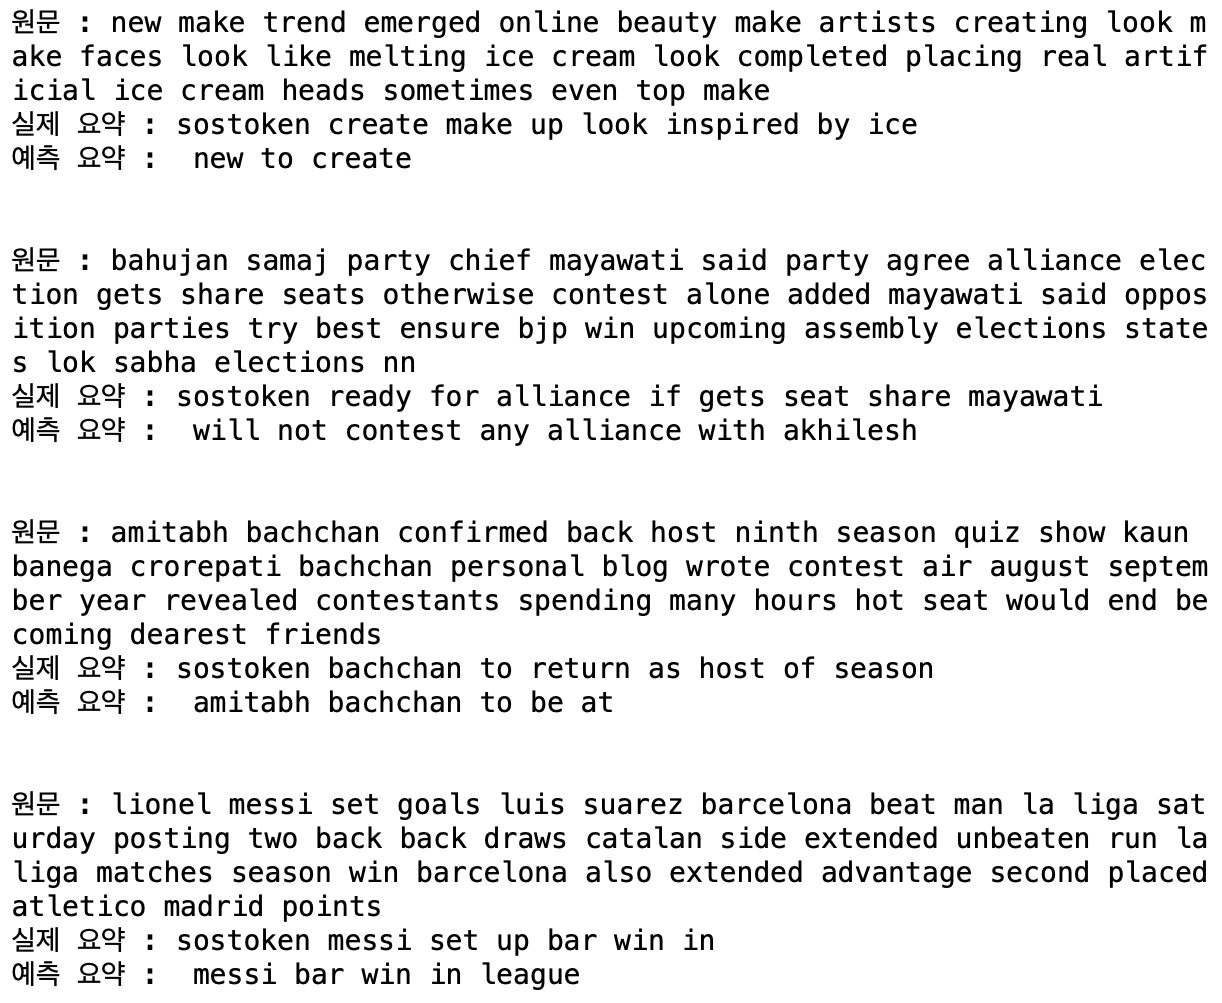

In [131]:
# 추상적 요약 결과 캡쳐
Image("./news_summarization/abstractive.png")

---
### 추출적 요약 분석
- 요약된 문장이 원문의 핵심적인 내용을 잘 반영하고 있고, 중요한 정보도 포함되어 있음
- 요약으로 출력하는 문장의 길이를 파라미터로 설정하는데, 이 요약이 짧게 나오지 못하도록 ratio나 words에 제약이 있는듯 함
    - (위 summarize 함수를 사용하는과정을 동해서 확인할 수 있음)
    - 요약에 긴 길이가 보장되어 있기에 더 많은 정보를 담을 수 있도록 해 중요한 정보가 많이 삽입될 수 있는듯
- 문단에서 핵심적인 문장들을 선택해서 이어붙이는 식으로 동작하는데, 문장의 개수가 적고 텍스트가 짧아서 좋은 결과가 나타난 것으로 유추

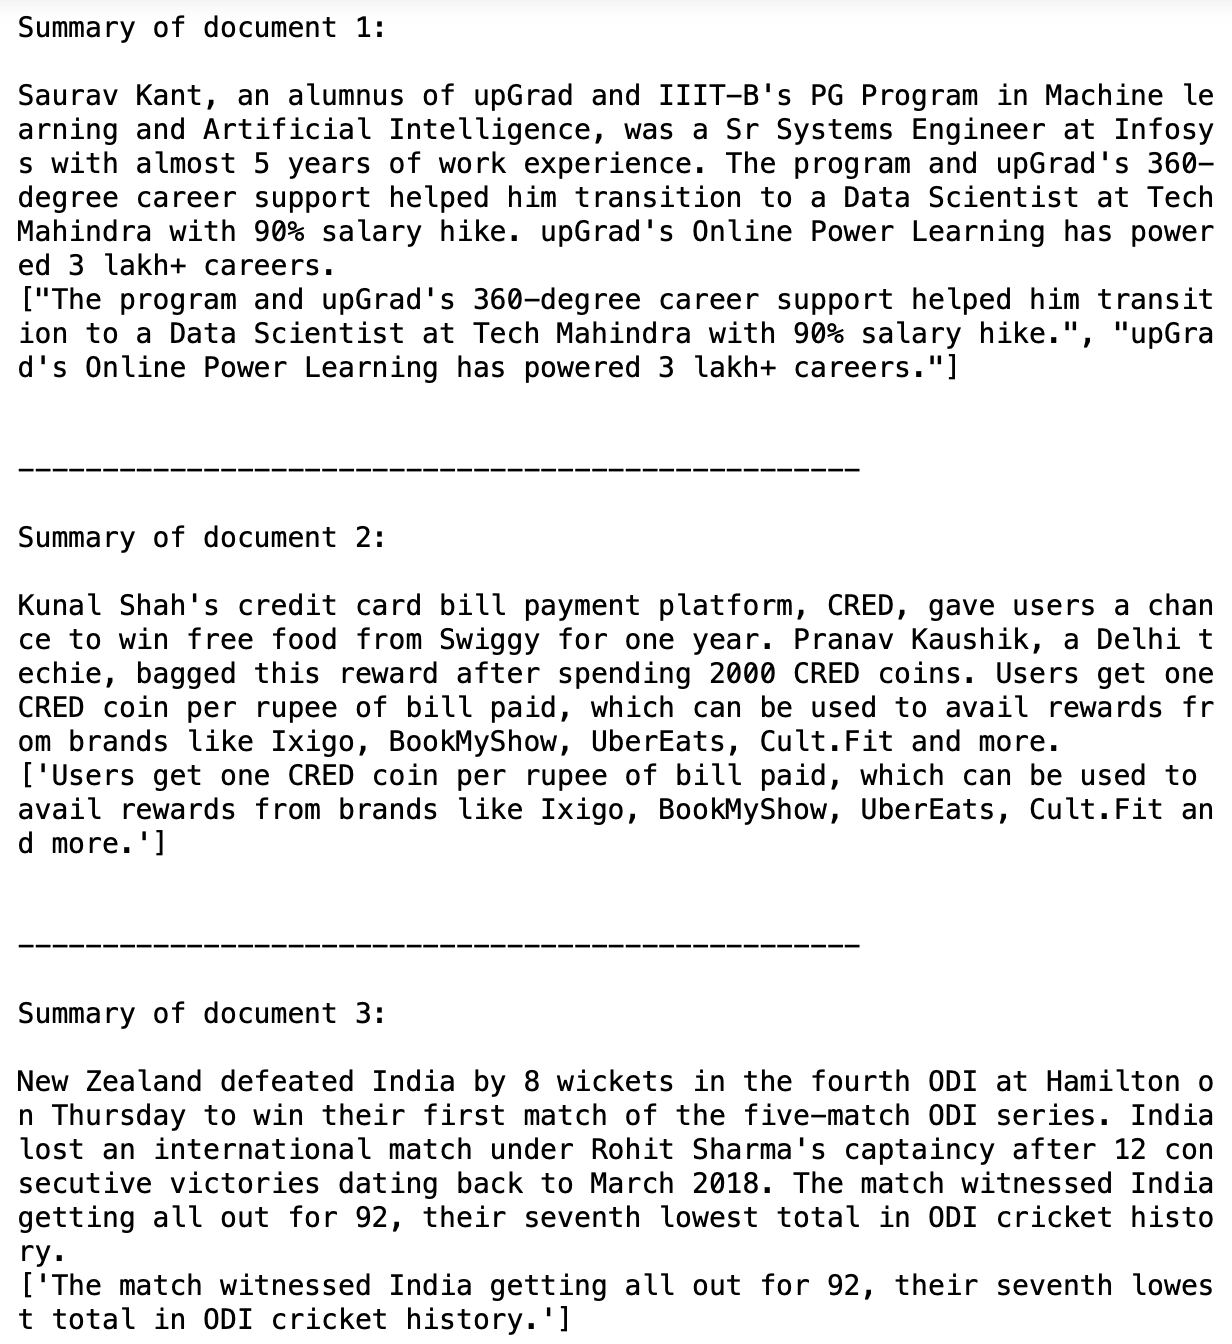

In [132]:
# 추출적 요약 결과 캡쳐
Image("./news_summarization/extractive.png")

### Extractive vs. Abstractive 비교
1. 문법 완성
    - Extractive : 전체 텍스트에서 문장을 가져오는 방식이기에 문법적 완성도가 높다.
    - Abstractive : 전체 텍스트를 통해 (확률기반으로) 문장을 생성하는 방식으로 문법적 완성도가 낮고 문장의 구성요소를 제대로 담고있지 않거나 문장이 완전하게 끝나지 않는 경우도 많다.
2. 핵심 단어 포함
    - Extractive : 중요한 문장은 핵심 단어를 많이 포함하고 있으므로 핵심 단어 포함 성능이 추상적 요약에 비해 비교적으로 좋다.
    - Abstractive : 이름이나 지명과 같은 핵심 단어는 잘 담지만 전체 내용을 아우르는 핵심 단어 포함 성능은 추출적 요약에 비해 많이 떨어진다.

---
### 회고
- 텍스트의 max_len을 선택하는 과정에서 직관성이 중요한 것 같은데, 어떤 크기의 인자를 사용할지에 대한 구체적인 지표가 있는지 궁금하다.
- 열심히 만들어놓은 추상적 요약에 비해 추출적 요약의 성능이 압도적으로 좋아서 의아했다. 추출적 요약이 중요한 문장을 선택하는 것은 어떤 메커니즘인지 궁금했다.
- 이번에는 단어 임베딩이 아니라 정수 인코딩을 통해서 진행했는데, 이 부분이 낮은 요약 성능에 영향을 미치지 않았을까 싶다. 요약 과제에서 단어 임베딩을 사용하는 예도 있는지 찾아봐야할 것 같다.